## 0.1. Load Angle Data
Loads bond angle data files into data frames, separating each line and then separating by spaces to be able to index by trial

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
from scipy import stats
import matplotlib
import pandas as pd
import os

def read_BondAngles(filename):
    dataset=pd.read_csv(filename, header=0, names=['bond_angles'], squeeze=True) # read BondAngles.txt raw, just returns rows as entries of a series
    dataset=dataset.str.split(expand=True) # split each series entry by space and expand into columns
    dataset['trialName']=dataset.groupby((dataset[0]=='>>>>>').cumsum())[1].transform(lambda x: x.max()) # group by trial dividers, recognized by >>>>>, and label each row with group name
    dataset=dataset[dataset[0]!='>>>>>']
    dataset.set_index('trialName', inplace=True)
    dataset=dataset.astype('float32')
    dataset=dataset.stack().rename('bondAngle').reset_index().drop('level_1', axis=1).set_index('trialName', append=True)
    dataset.index=dataset.index.swaplevel()
    return dataset


filenames={'non0_07-11':'simulation_data/non_BondAngles07-11.txt', 'non0_07-13':'simulation_data/non_BondAngles07-13.txt',
           'non0_08-02':'simulation_data/ZeroPinData/non_BondAngles08-02.txt', 'non0_06-20':'simulation_data/ZeroPinData/non_BondAngles06-20.txt',
           'squ16_08-05':'simulation_data/squ_BondAnglesNp16_08-05.txt', 'squ64_08-05':'simulation_data/squ_BondAnglesNp64_08-05.txt','squ36_07-11':'simulation_data/squ_BondAngles07-11.txt',
           'squ64_07-12':'simulation_data/squ_BondAngles07-12.txt', 'squ64_07-13':'simulation_data/squ_BondAngles07-13.txt',
           'tri36_07-11':'simulation_data/tri_BondAngles07-11.txt', 'tri64_08-08':'simulation_data/tri_BondAnglesNp64_08-08.txt', 'tri64_07-12':'simulation_data/tri_BondAngles07-12.txt',
           'ran36_07-11':'simulation_data/ran_BondAngles07-11.txt', 'squ100_07-19':'simulation_data/squ_BondAngles07-19.txt', 'tri100_07-19':'simulation_data/tri_BondAngles07-19.txt', 'ran100_07-19':'simulation_data/ran_BondAngles07-19.txt'}

#files = ['non0_07-11', 'squ36_07-11', 'squ64_07-12', 'tri36_07-11', 'tri64_07-12', 'ran36_07-11', 'squ100_07-19', 'tri100_07-19', 'ran100_07-19']
files=['tri36_07-11','tri64_07-12','tri100_07-19','squ36_07-11','squ64_07-12','squ100_07-19']
dataDict={file:read_BondAngles(filenames[file]) for file in files}

## 0.2. Load Bond Data
Combines normalized forces of the bonds with their angles for graphing

In [7]:
def read_BondInfo(filename, dfAngles):
    filePath=filename.split('/')
    filePath[-1]=filePath[-1].replace('Angles','Info')
    dataset=pd.read_csv('/'.join(filePath), usecols=range(7), sep=' ', header=0, names=['x1','y1','x2','y2','energy','force','bondType']) # read bondInfo.txt
    dataset['trialName']=dataset.groupby((dataset.x1=='>>>>>').cumsum())['y1'].transform(lambda x: x.max()) # group by trial dividers, recognized by >>>>>, and label each row with group name
    dataset = dataset[dataset.x1 != '>>>>>'].reset_index(drop=True) # remove trial dividers

    # Generate higher level index
    dataset.index.rename('rowNumber', inplace=True)
    dataset.set_index('trialName',append=True,inplace=True)
    dataset.index=dataset.index.swaplevel()
    dataset=dataset.astype('float32') # convert all columns to float32 - 7 decimal places of precision is plenty
    dataset['bondType']=dataset['bondType'].astype('int16') # except bond type, which is a column of integers
    dataset['normalizedForce']=dataset.groupby('trialName')['force'].transform(lambda x: x/x.mean())
    return pd.concat([dataset[['normalizedForce','bondType']],dfAngles],axis=1)

dataDict={file:read_BondInfo(filenames[file], dataDict[file]['bondAngle']) for file in files}

## 1.1. Mean Force vs. Bond Angle

In [8]:
bw = 2*stats.iqr(squ36['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(squ36)**(1/3)) # Freedman-Diaconis rule for histogram bin width
num_bins=int(np.pi/bw)
angleBins=squ36.groupby(pd.cut(squ36['bondAngle'],np.linspace(0,np.pi,num_bins))).agg({'normalizedForce':['mean','sem'],'bondAngle':['mean','sem']})
print('number of bins:', num_bins)

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_xlim(0,np.pi)
for angle in np.linspace(0,np.pi,11):
    plt.axvline(x=angle, alpha=0.4)
plt.errorbar(angleBins['bondAngle','mean'], angleBins['normalizedForce','mean'],xerr=angleBins['bondAngle','sem'],yerr=angleBins['normalizedForce','sem'],fmt='C0.')
print('Cosmetics:')
ax.set_title('mean force vs. bond angle for 64 pin square lattice', x=0.5,y=0.82)
ax.set_xlabel('')
ax.set_ylabel('')
plt.figtext(0.51, 0.25, 'normalized force', ha='center')
print(plt.ylim())
#plt.savefig('plots/force_vs_angle-squ64.png', dpi=300)
plt.show()

NameError: name 'squ36' is not defined

## 1.2. Bond Angle Histograms

In [ ]:
fig, axes = plt.subplots(len(files), 1, figsize=(8,8))
for counter, (file, ax) in enumerate(zip(files,axes),1):
    bw = 2*stats.iqr(dataDict[file]['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3)) # Freedman-Diaconis rule for histogram bin width
    num_bins=int(np.pi/bw)
    ax.hist(dataDict[file]['bondAngle'], bins=num_bins, histtype='step', density=True, color='C{}'.format(counter-1))
    ax.set_ylim(0.2,0.45)
    ax.set_title('{} Pin Square Lattice'.format(file.split('_')[0][3:]))
    ax.set_xlim(0,np.pi)

plt.tight_layout()
plt.savefig('plots/presentation/squ_bondangles.png', dpi=300)

In [ ]:
# fig, axes = plt.subplots(len(files), 1, figsize=(8,10))
matplotlib.rcParams['text.usetex'] = True
bondTypes=['small-small', 'small-large', 'large-large', 'small-pin', 'large-pin']
for counter, (file, ax) in enumerate(zip(files,axes),1):
    for bondGroup in dataDict[file].groupby('bondType'):
        bw = 2*stats.iqr(bondGroup[1]['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(bondGroup[1])**(1/3)) # Freedman-Diaconis rule for histogram bin width
        #num_bins=int(np.pi/bw)
        num_bins=80
        ax.hist(bondGroup[1]['bondAngle'], label=bondTypes[bondGroup[0]], bins=num_bins, histtype='step')

    lengthscale=dataDict[file].index.get_level_values(0)[0].split('-')[-2:]
    Lambda=float(lengthscale[0])/float(lengthscale[1])
    ax.set_title('{} Pin Triangle Lattice,  $\lambda_A={l:.3f}, \lambda_B={l2:.3f}$'.format(file.split('_')[0][3:],l=Lambda,l2=Lambda*1.4))
    ax.set_xlim(0,np.pi)
axes[0].legend(loc=(0.85,0.65))

#plt.figtext(0.51, 0.25, 'counts', ha='center')
#ax.set_yticks([0,5000,10000,15000])
#ax.set_title('Bond Angle Distributions, August 2019 Data', x=0.5,y=0.82)

#plt.savefig('plots/presentation/bondAnglesbyType-tri.png', dpi=300)
fig.tight_layout()
plt.show()

In [ ]:
files=['tri64_07-12','tri100_07-19']
period=np.pi/3
fig, axes = plt.subplots(len(files), 3, sharex=True, figsize=(16,7))
matplotlib.rcParams['text.usetex'] = True
bondTypes=['small-small', 'small-large', 'large-large', 'small-pin', 'large-pin']
for file, (ax2, ax, axHist) in zip(files,axes):
    dataDict[file]['bondAngle']%=period
    for colorCounter, bondGroup in enumerate(dataDict[file].groupby('bondType')):
        bw = 2*stats.iqr(bondGroup[1]['bondAngle'],rng=(25,75), scale=1.0, nan_policy='omit')/(len(bondGroup[1])**(1/3)) # Freedman-Diaconis rule for histogram bin width
        num_bins=int(period/bw)
        #num_bins=20
        angleBins=bondGroup[1].groupby(pd.cut(bondGroup[1]['bondAngle'],np.linspace(0,period,num_bins))).agg({'normalizedForce':['mean', 'sem'],'bondAngle':['mean', 'sem']})
        ax.fill_between(angleBins['bondAngle','mean'], angleBins['normalizedForce','mean']-angleBins['normalizedForce','sem'], angleBins['normalizedForce','mean']+angleBins['normalizedForce','sem'],alpha=0.2,fc='C{}'.format(colorCounter),ec='none')
        ax.fill_betweenx(angleBins['normalizedForce','mean'],angleBins['bondAngle','mean']-angleBins['bondAngle','sem'], angleBins['bondAngle','mean']+angleBins['bondAngle','sem'],alpha=0.2,fc='C{}'.format(colorCounter),ec='none')
        ax.plot(angleBins['bondAngle','mean'], angleBins['normalizedForce','mean'], label=bondTypes[bondGroup[0]], color='C{}'.format(colorCounter), alpha=0.5)
        axHist.hist(bondGroup[1]['bondAngle'], label=bondTypes[bondGroup[0]], bins=num_bins, histtype='step')

    bw = 2*stats.iqr(dataDict[file]['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3)) # Freedman-Diaconis rule for histogram bin width
    num_bins=int(period/bw)
    angleBins=dataDict[file].groupby(pd.cut(dataDict[file]['bondAngle'],np.linspace(0,np.pi,num_bins))).agg({'normalizedForce':['mean', 'sem'],'bondAngle':['mean', 'sem']})
    ax2.fill_between(angleBins['bondAngle','mean'], angleBins['normalizedForce','mean']-angleBins['normalizedForce','sem'],
                    angleBins['normalizedForce','mean']+ angleBins['normalizedForce','sem'], alpha=0.2, fc='C0', ec='none')
    ax2.fill_betweenx(angleBins['normalizedForce','mean'],angleBins['bondAngle','mean']-angleBins['bondAngle','sem'], angleBins['bondAngle','mean']+angleBins['bondAngle','sem'],alpha=0.2,fc='C0',ec='none')
    ax2.plot(angleBins['bondAngle','mean'], angleBins['normalizedForce','mean'])
    lengthscale=dataDict[file].index.get_level_values(0)[0].split('-')[-2:]
    Lambda=float(lengthscale[0])/float(lengthscale[1])
    ax.set_title('{} Pin Triangle Lattice,  $\lambda_A={l:.3f}, \lambda_B={l2:.3f}$'.format(file.split('_')[0][3:],l=Lambda,l2=Lambda*1.4))
    plt.xticks(ticks=[0,np.pi/12,np.pi/6,np.pi/4,np.pi/3,5*np.pi/12,np.pi/2], labels=['0','$\pi/12$','$\pi/6$','$\pi/4$','$\pi/3$','$5\pi/12$','$\pi/2$'])
    ax.set_xlim(0,period)
axes[0,2].legend(loc='upper right')
axes[1,0].set_ylabel('average normalized force')
axes[1,2].set_ylabel('counts')

#plt.figtext(0.51, 0.25, 'counts', ha='center')
#ax.set_yticks([0,5000,10000,15000])
#ax.set_title('Bond Angle Distributions, August 2019 Data', x=0.5,y=0.82)

fig.tight_layout()
plt.savefig('plots/presentation/bondForcesAnglesTotal-tri.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
matplotlib.rcParams['text.usetex'] = False
ax = fig.add_subplot(111, projection='polar')
for angle in np.linspace(0,np.pi,11):
    plt.axvline(angle, alpha=0.4)
#plt.axvline(5*np.pi/6, alpha=0.4)
for file in ['squ64_07-12']:
    bw = 2*stats.iqr(dataDict[file]['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3)) # Freedman-Diaconis rule for histogram bin width
    num_bins=int(np.pi/bw)
    plt.hist(dataDict[file]['bondAngle'], bins=num_bins, density=True, histtype='step', label=file)

plt.xlim(0,np.pi)
plt.ylim(0,0.36)
plt.legend(loc=(0.85,0.65))
ax.set_xlabel('')
plt.figtext(0.51, 0.25, 'probability density', ha='center')
ax.set_title('Normalized Comparison of Bond Angle Distributions, July 2020 Square Lattice', x=0.5,y=0.82)
plt.savefig('plots/bond_angle_distribution-squares-squ64_07_2020.png', dpi=300)
plt.show()

## 1.3. Averaging Mean Force vs. Bond Angle

In [ ]:
xrange=(np.pi/20,3*np.pi/20)
data['bondAngle_mod']=np.mod(data['bondAngle']-xrange[0], xrange[1]-xrange[0])+xrange[0]
bw = 2*stats.iqr(data['bondAngle_mod'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(data)**(1/3)) # Freedman-Diaconis rule for histogram bin width
num_bins=int((xrange[1]-xrange[0])/bw)
print('number of bins:', num_bins)
angleBins_mod=data.groupby(pd.cut(data['bondAngle_mod'],np.linspace(xrange[0],xrange[1],num_bins))).agg({'normalizedForce':['mean','sem'],'bondAngle_mod':['mean','sem']})

fig = plt.figure()
ax = fig.add_subplot(111)
print('Plotting:')
plt.errorbar(angleBins_mod['bondAngle_mod','mean'], angleBins_mod['normalizedForce','mean'],xerr=angleBins_mod['bondAngle_mod','sem'],yerr=angleBins_mod['normalizedForce','sem'],fmt='C0.')
print('Cosmetics:')
ax.set_title('mean force vs. bond angle for 64 pin square lattice, averaged over one period')#, x=0.5,y=0.82)
#plt.figtext(0.51, 0.25, 'normalized force', ha='center')
plt.ylabel('normalized force')
plt.xlabel('bond angle (degrees)')

#plt.savefig('plots/force_vs_angle-squ64-errorbars.png', dpi=300)
plt.show()

In [ ]:
f = lambda x: np.cos(x)**2*np.sin(x)**2
ODFs = np.array([])
for file in files:
    ODF=1/len(dataDict[file])*(f(dataDict[file]['bondAngle'])).sum()
    ODFs=np.append(ODFs, [file,file[:3],int(dataDict[file].index.get_level_values(0)[0].split('-')[3]),ODF]).reshape(-1,4)
ODFs=pd.DataFrame(ODFs, columns=['file','geo','num_pins','ODF']).astype({'num_pins':'int', 'ODF':'float'})

In [ ]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plt.figure(figsize=(8,8))
for geo in ODFs.groupby('geo'):
    if geo[0]=='non':
        marker='X'
    elif geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    elif geo[0]=='ran':
        marker='d'
    plt.plot(geo[1]['num_pins']/(geo[1]['num_pins']+230), geo[1]['ODF'], marker, label=geo[0])
plt.legend()
plt.xlabel('pins/total')
plt.ylabel('nnormalized orientation distribution function')
plt.figtext(0.44,0.75,r'$\displaystyle\int_0^\pi f(\theta)\cos^2\theta\sin^2\theta d\theta$', ha='center', fontsize=12)
plt.figtext(0.5,0.69,r'$\displaystyle\frac{1}{M}\sum^M_i\cos^2\theta_i\sin^2\theta_i$', ha='center', fontsize=16)
plt.title('Normalized ODF vs $w_{pins}$')
plt.savefig('plots/nODF-july-comparison_all.png', dpi=300)

## 1.4. Binning Bond Angle Distributions by Strength

In [72]:
dataDict[file].sort_values(by='normalizedForce').iloc[0:round(len(dataDict[file])/4)]

,,normalizedForce,bondType,bondAngle
trialName,rowNumber,,,
squ-21705-330-100-.0274-.1,506099,0.000007,2,2.744460
squ-22237-330-100-.0274-.1,660503,0.000013,2,1.769340
squ-20920-330-100-.0274-.1,269201,0.000020,0,0.999425
squ-22611-330-100-.0274-.1,764188,0.000020,1,0.675061
squ-21158-330-100-.0274-.1,342119,0.000022,1,2.214750
...,...,...,...,...
squ-20118-330-100-.0274-.1,39118,0.305793,3,0.739742
squ-21139-330-100-.0274-.1,337102,0.305794,0,1.547000
squ-22097-330-100-.0274-.1,620421,0.305795,1,0.495053


-11.837524
21614 28 (0.00585, 0.0357]
133163 51 (0.0357, 0.218]
504284 79 (0.218, 1.329]
214053 59 (1.329, 8.107]
2175 13 (8.107, 49.456]


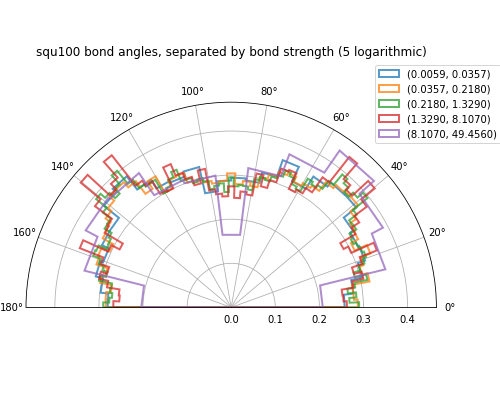

In [177]:
num_bins=6
for file in ['squ100_07-19']:
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111, projection='polar')
#    for bin in range(num_bins):
#        #print(bin*int(len(dataDict[file])/4),(bin+1)*int(len(dataDict[file])/4))
#        dataBin=dataDict[file].sort_values(by='normalizedForce').iloc[bin*int(len(dataDict[file])/num_bins):(bin+1)*int(len(dataDict[file])/num_bins)]
#        forceGroup=(pd.Interval(dataBin['normalizedForce'].min(), dataBin['normalizedForce'].max()), dataBin)
#        #print(forceGroup[0])
    print(np.log(dataDict[file]['normalizedForce'].min()))
    #for forceGroup in dataDict[file].groupby(pd.cut(dataDict[file]['normalizedForce'],np.exp(np.linspace(np.log(dataDict[file]['normalizedForce'].min()),np.log(dataDict[file]['normalizedForce'].max()),num_bins)))):
    for forceGroup in dataDict[file].groupby(pd.cut(dataDict[file]['normalizedForce'],np.exp(np.linspace(np.log10(dataDict[file]['normalizedForce'].min()),np.log(dataDict[file]['normalizedForce'].max()),num_bins)))):
        bw = 2*stats.iqr(forceGroup[1]['bondAngle'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(forceGroup[1])**(1/3)) # Freedman-Diaconis rule for histogram bin width
        print(len(forceGroup[1]), int(np.pi/bw), forceGroup[0])
        ax.hist(forceGroup[1]['bondAngle'], linewidth=2, bins=int(np.pi/bw), histtype='step', alpha=0.75, density=True, label='({left:.4f}, {right:.4f})'.format(left=forceGroup[0].left, right=forceGroup[0].right))
ax.set_xlim(0,np.pi)
ax.set_title('squ100 bond angles, separated by bond strength (5 logarithmic)',x=0.5,y=0.85)
ax.legend(loc=(0.85,0.65))
plt.tight_layout()
#plt.savefig('plots/bond_angles-force_bins_5log-squ100.jpg', dpi=300)